# Estimation of simulated VAR by ML using PyTorch

## Libraries

In [10]:
import matplotlib.pyplot as plt
import torch
import math

## Simulation of stationary time-series

In [2]:
# Time-series dimension of simulation

nsample = 1000
nvar = 4

In [3]:
# Create null data frames for storing data

df = torch.empty((nsample, nvar))
rho = torch.empty((nvar))

In [4]:
# Simulation of processes

# Start values

for i in range(0, df.shape[1]):
    df[0,i] = torch.rand(1)
    
# Rho parameters, smaller than one in absolute value
for i in range(0, df.shape[1]):
    rho[i] = torch.rand(1)

# Create the AR(1) processes
for i in range(1,df.shape[0]):
    for j in range(0, df.shape[1]):
        df[i,j] = rho[j]*df[i-1, j] + torch.randn(1)

print(df)

tensor([[ 0.0776,  0.1814,  0.7793,  0.4294],
        [-1.4246,  0.2893, -0.9785,  0.6935],
        [-0.2628, -0.6931, -1.3306,  1.6691],
        ...,
        [ 2.3583,  0.9647, -0.0736,  1.2901],
        [ 3.3645, -1.0167, -0.2308, -0.0752],
        [ 3.5662, -0.8805,  0.9227,  0.5925]])


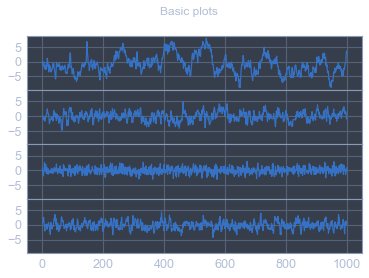

In [5]:
# Plots

f, axarr = plt.subplots(df.shape[1], sharex=True, sharey=True)
f.suptitle('Basic plots')

for i in range(0, df.shape[1]):
    axarr[i].plot(df[:,i].numpy())

# Bring subplots close to each other.
f.subplots_adjust(hspace=0)

# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()

## VAR

In [156]:
class VAR:
    """ 
    **** VECTOR AUTOREGRESSION (VAR) MODELS ****
    ----------
    Parameters
    data : np.array
        Field to specify the time series data that will be used.
    lags : int
        Field to specify how many lag terms the model will have. 
    integ : int (default : 0)
        Specifies how many time to difference the dependent variables.
    target : str (pd.DataFrame) or int (np.array) (default : None)
        By default, all columns will be selected as the dependent variables.
    """

    def __init__(self,data,lags,target=None,integ=0):
        
        # Latent Variables
        self.lags = lags
        self.integ = integ
        self.target = target
        self.model_name = "VAR(" + str(self.lags) + ")"
        
        # Format the dependant variables
        self.data = data
        self.T = data.shape[0]
        self.ylen = data.shape[1]
        
        # Format the independent variables
        
        ## TO DO
        
#         # Difference data
#         X = np.transpose(self.data)
#         for order in range(self.integ):
#             X = np.asarray([np.diff(i) for i in X])
#             self.data_name = np.asarray(["Differenced " + str(i) for i in self.data_name])
#         self.data = X.T
        
        """
        Y : torch.array
            Contains the length-adjusted time series (accounting for lags)
        """     

        self.Y = torch.t(self.data[self.lags:,])
        
    def _design(self):
        """ Creates a design matrix
        Z : np.array
        """ 
        
        Z = torch.ones(((self.ylen*self.lags+1), (self.T-self.lags)))

        row_count=1
        for lag in range(1, self.lags+1):
            for reg in range(self.ylen):
                Z[row_count, :] = self.data[:,reg][(self.lags-lag):-lag]
                row_count += 1
                
        return(Z)

    def OLS(self):
        """ Creates OLS coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix B
        """         
        
        Z = self._design()
        return torch.mm(torch.mm(self.Y,torch.t(Z)),torch.inverse(torch.mm(Z,torch.t(Z))))
    
    def MLE(self):
        """ Creates MLE coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix MLE
        ----------
        It is based on the assumption of normality of errors
        """     
        
        par = torch.ones((self.ylen)**2 + self.ylen + self.ylen, requires_grad=True)
        
        coef = torch.reshape(par[0:self.ylen**2], (self.ylen, self.ylen))
        coef_mean = par[self.ylen**2:self.ylen**2+self.ylen]
        coef_var = torch.diag(par[self.ylen**2+self.ylen:])    
        Z = self._design()[1:]

        Y_0 = torch.t(torch.t(self.Y) - coef_mean)
        Z_0 = torch.t(torch.t(Z) - coef_mean)
        
        learning_rate = 1e-4
        optimizer = torch.optim.LBFGS(params = [par], lr=learning_rate)
        
        def closure():
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the Tensors it will update (which are the learnable weights
            # of the model)
            optimizer.zero_grad()
            
            # First way (without a constant term in the likelihood function):
            loss = -( - .5*self.Y.shape[1]*torch.log(torch.abs(torch.det(coef_var))) - .5*torch.trace(torch.mm(torch.mm(torch.t(Y_0 - torch.mm(coef,Z_0)),torch.inverse(coef_var)),Y_0 - torch.mm(coef,Z_0))))

#              TO ADD: 
#             Second way:
#             dist = torch.distributions.MultivariateNormal(torch.mm(coef,Z_0), coef_var)
#             loss = -torch.mean(dist.log_prob(Y_0))
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            return loss
        
        # Calling the step function on an Optimizer makes an update to its parameters
        for i in range(100):
            optimizer.step(closure)
            
        return(par)

In [157]:
# Estimate VAR(1) by MLE

MLE_results = VAR(data = df, lags = 1, target = None, integ = 0).MLE()
MLE_results

par_names_MLE = ['A AR(1)','B to A AR(1)','C to A AR(1)','D to A AR(1)',
                 'B AR(1)','A to B AR(1)','C to B AR(1)','D to B AR(1)',
                 'C AR(1)','A to C AR(1)','B to C AR(1)', 'D to C AR(1)',
                 'D AR(1)','A to D AR(1)','B to D AR(1)', 'C to D AR(1)',
                 'A Constant','B Constant', 'C Constant', 'D Constant',
                 'Var(A)','Var(B)','Var(C)','Var(D)'] 

results_MLE = dict(zip(par_names_MLE, MLE_results.flatten()))
results_MLE

{'A AR(1)': tensor(0.9424, grad_fn=<SelectBackward>),
 'B to A AR(1)': tensor(0.0787, grad_fn=<SelectBackward>),
 'C to A AR(1)': tensor(0.2686, grad_fn=<SelectBackward>),
 'D to A AR(1)': tensor(0.1743, grad_fn=<SelectBackward>),
 'B AR(1)': tensor(0.1225, grad_fn=<SelectBackward>),
 'A to B AR(1)': tensor(0.6906, grad_fn=<SelectBackward>),
 'C to B AR(1)': tensor(0.3313, grad_fn=<SelectBackward>),
 'D to B AR(1)': tensor(0.2692, grad_fn=<SelectBackward>),
 'C AR(1)': tensor(0.1676, grad_fn=<SelectBackward>),
 'A to C AR(1)': tensor(0.2174, grad_fn=<SelectBackward>),
 'B to C AR(1)': tensor(0.4685, grad_fn=<SelectBackward>),
 'D to C AR(1)': tensor(0.2629, grad_fn=<SelectBackward>),
 'D AR(1)': tensor(0.1495, grad_fn=<SelectBackward>),
 'A to D AR(1)': tensor(0.2162, grad_fn=<SelectBackward>),
 'B to D AR(1)': tensor(0.3566, grad_fn=<SelectBackward>),
 'C to D AR(1)': tensor(0.6410, grad_fn=<SelectBackward>),
 'A Constant': tensor(2.4546, grad_fn=<SelectBackward>),
 'B Constant': tens

In [38]:
# Estimate VAR(1) by OLS

# In general

OLS_results = VAR(data = df, lags = 1, target = None, integ = 0).OLS()
OLS_results

# For more clarity

par_names_OLS = ['A Constant','A AR(1)','B to A AR(1)','C to A AR(1)','D to A AR(1)',
                 'B Constant','B AR(1)','A to B AR(1)','C to B AR(1)','D to B AR(1)',
                 'C Constant','C AR(1)','A to C AR(1)','B to C AR(1)', 'D to C AR(1)',
                 'D Constant','D AR(1)','A to D AR(1)','B to D AR(1)', 'C to D AR(1)'] 

results_OLS =  dict(zip(par_names_OLS, OLS_results.flatten()))
results_OLS

{'A Constant': tensor(-0.0465),
 'A AR(1)': tensor(0.9444),
 'B to A AR(1)': tensor(-0.0108),
 'C to A AR(1)': tensor(-0.0054),
 'D to A AR(1)': tensor(0.0225),
 'B Constant': tensor(-0.0218),
 'B AR(1)': tensor(3.9784e-05),
 'A to B AR(1)': tensor(0.7540),
 'C to B AR(1)': tensor(-0.0291),
 'D to B AR(1)': tensor(0.0379),
 'C Constant': tensor(-0.0206),
 'C AR(1)': tensor(0.0017),
 'A to C AR(1)': tensor(0.0113),
 'B to C AR(1)': tensor(0.0811),
 'D to C AR(1)': tensor(-0.0458),
 'D Constant': tensor(-0.0389),
 'D AR(1)': tensor(0.0087),
 'A to D AR(1)': tensor(0.0380),
 'B to D AR(1)': tensor(-0.0016),
 'C to D AR(1)': tensor(0.6578)}